## 2.1 Cleaning and Preparation of Dataset
### 2.1.1 Data Load
The first step in the data analysis process is to load the data into a pandas DataFrame. 

As analyzed in the data exploration section, the data is stored in a CSV file that doesn't include a header row. The data is loaded into a pandas DataFrame and headers are added manually.

**Note:** I am importing the `utils.py` file to implement graphing functions.

In [1]:
import pandas as pd
import utils

df = pd.read_csv("datasets/census_income.csv")

# Column names added to the dataset
attribute_names = [ # Improving clarity of names
    "age",
    "workclass",
    "final_weights",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income"
]

df.columns = attribute_names
df.head()

,age,workclass,final_weights,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


### 2.1.2 Data Cleaning: Handling Missing Values

My exploratory analysis revealed missing values in the dataset. Althought they were not empty, missingness was represented as question marks on some of the categorical columns. As stated in the ***Data Quality*** section of the data exploration notebook, I will replace these question marks as a missing category (Replacing them with any other value such as the mode or median would be counterproductive as it would bias the analysis towards the most common values).

C:\Users\danie\AppData\Local\Temp\ipykernel_34748\1384496257.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


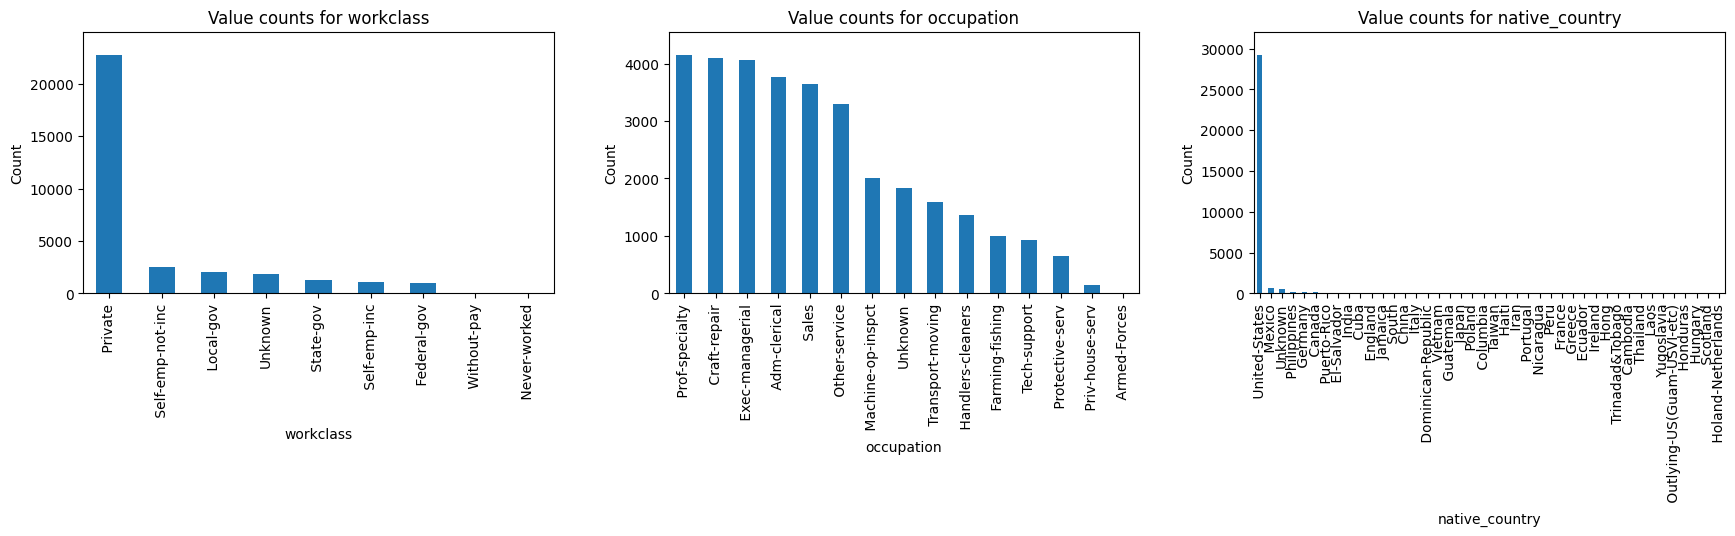

In [2]:
df['workclass'] = df['workclass'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)
df['occupation'] = df['occupation'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)
df['native_country'] = df['native_country'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)

fig = utils.plot_categorical_value_counts(df, ['workclass', 'occupation', 'native_country'])
fig.show()

Missing values handled.

### 2.1.3 Data Cleaning: Handling Duplicates

Several duplicates were found in the dataset. I arrived to the conclusion that these were errors in the data collection process, and would need to be dropped. This was done using the `drop_duplicates()` method, using the `keep="first"` parameter to keep the first occurrence of each duplicate as this is relevant to the analysis.

In [3]:
df = df.drop_duplicates(keep='first')
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


### 2.1.4 Format Standardization

Standarization is key to ensuring data quality and efficient storing. Steps needed to take are:

1. The relationship between both `education_num` and `education` columns can be explained by a dictionary. This is a good way to save storage and still represent the same data. I am going to create a dictionary to map the values of `education_num` to the values of `education` and drop the `education_num` column.
2. Standarize the `workclass` column by arranging classes with similar meaning in the same category, using a predefined dictionary.
3. Binning the `age` column into 5 intervals in order to reduce the number of unique values and make the data more manageable. Possible drop the `age` column.
4. Standarize the `marital_status` column by arranging classes with similar meaning in the same category, using a predefined dictionary. I noticed that I have both husband and wife, but this could be defined as married.

In [4]:
# 1. Implementing the Dictionary

education_num_dict = df[['education_num','education']].drop_duplicates().set_index('education')['education_num'].to_dict()
df.drop(columns=['education_num'], inplace=True)
print(f'Resultant Dictionary:\n {education_num_dict}')


# 2. Implementing the workclass standardization
workclass_map = {
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Federal-gov': 'Government',
    'State-gov': 'Government',
    'Local-gov': 'Government',
    'Private': 'Private',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}
df['workclass'] = df['workclass'].apply(lambda x: workclass_map[x.strip()] 
                                        if x.strip() in workclass_map else x.strip())
print("Showing workclass value counts:\n", df['workclass'].value_counts())

# 3. Binning the age column
age_bins = [0, 25, 35, 50, 65, 100]
age_labels = ['18-25', '26-35', '36-50', '51-65', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

#4. Implementing the marital status standardization
df['relationship'] = df['relationship'].apply(lambda x: 'Married' 
                                                        if x.strip().lower() in ['husband', 'wife'] 
                                                        else x.strip().lower())
print("Showing relationship value counts:\n", df['relationship'].value_counts())


Resultant Dictionary:
 {' Bachelors': 13, ' HS-grad': 9, ' 11th': 7, ' Masters': 14, ' 9th': 5, ' Some-college': 10, ' Assoc-acdm': 12, ' Assoc-voc': 11, ' 7th-8th': 4, ' Doctorate': 16, ' Prof-school': 15, ' 5th-6th': 3, ' 10th': 6, ' 1st-4th': 2, ' Preschool': 1, ' 12th': 8}
Showing workclass value counts:
 workclass
Private          22673
Government        4350
Self-employed     3656
Unknown           1836
Other               21
Name: count, dtype: int64
Showing relationship value counts:
 relationship
Married           14755
not-in-family      8291
own-child          5064
unmarried          3445
other-relative      981
Name: count, dtype: int64


### 2.1.5. Convert Data Types
The only columns that I considered converting were the capital related columns from `int64` to `float64`. This is because althought the values are approximanted to integer values, there may be a need for a more detailed visual on the money values.
- The `income` column can only have two values, `<=50K` and `>50K`, but I'm not converting it to a boolean value as I prioritize clarity in my EDA process.

In [5]:
df['capital_gain'] = df['capital_gain'].astype(float)
df['capital_loss'] = df['capital_loss'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32536 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32536 non-null  int64   
 1   workclass       32536 non-null  object  
 2   final_weights   32536 non-null  int64   
 3   education       32536 non-null  object  
 4   marital_status  32536 non-null  object  
 5   occupation      32536 non-null  object  
 6   relationship    32536 non-null  object  
 7   race            32536 non-null  object  
 8   sex             32536 non-null  object  
 9   capital_gain    32536 non-null  float64 
 10  capital_loss    32536 non-null  float64 
 11  hours_per_week  32536 non-null  int64   
 12  native_country  32536 non-null  object  
 13  income          32536 non-null  object  
 14  age_group       32536 non-null  category
dtypes: category(1), float64(2), int64(3), object(9)
memory usage: 3.8+ MB


Categorical columns should be replotted in order to check my changes: 

C:\Users\danie\AppData\Local\Temp\ipykernel_34748\1334903311.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  utils.plot_categorical_value_counts(df, categorical_columns).show()


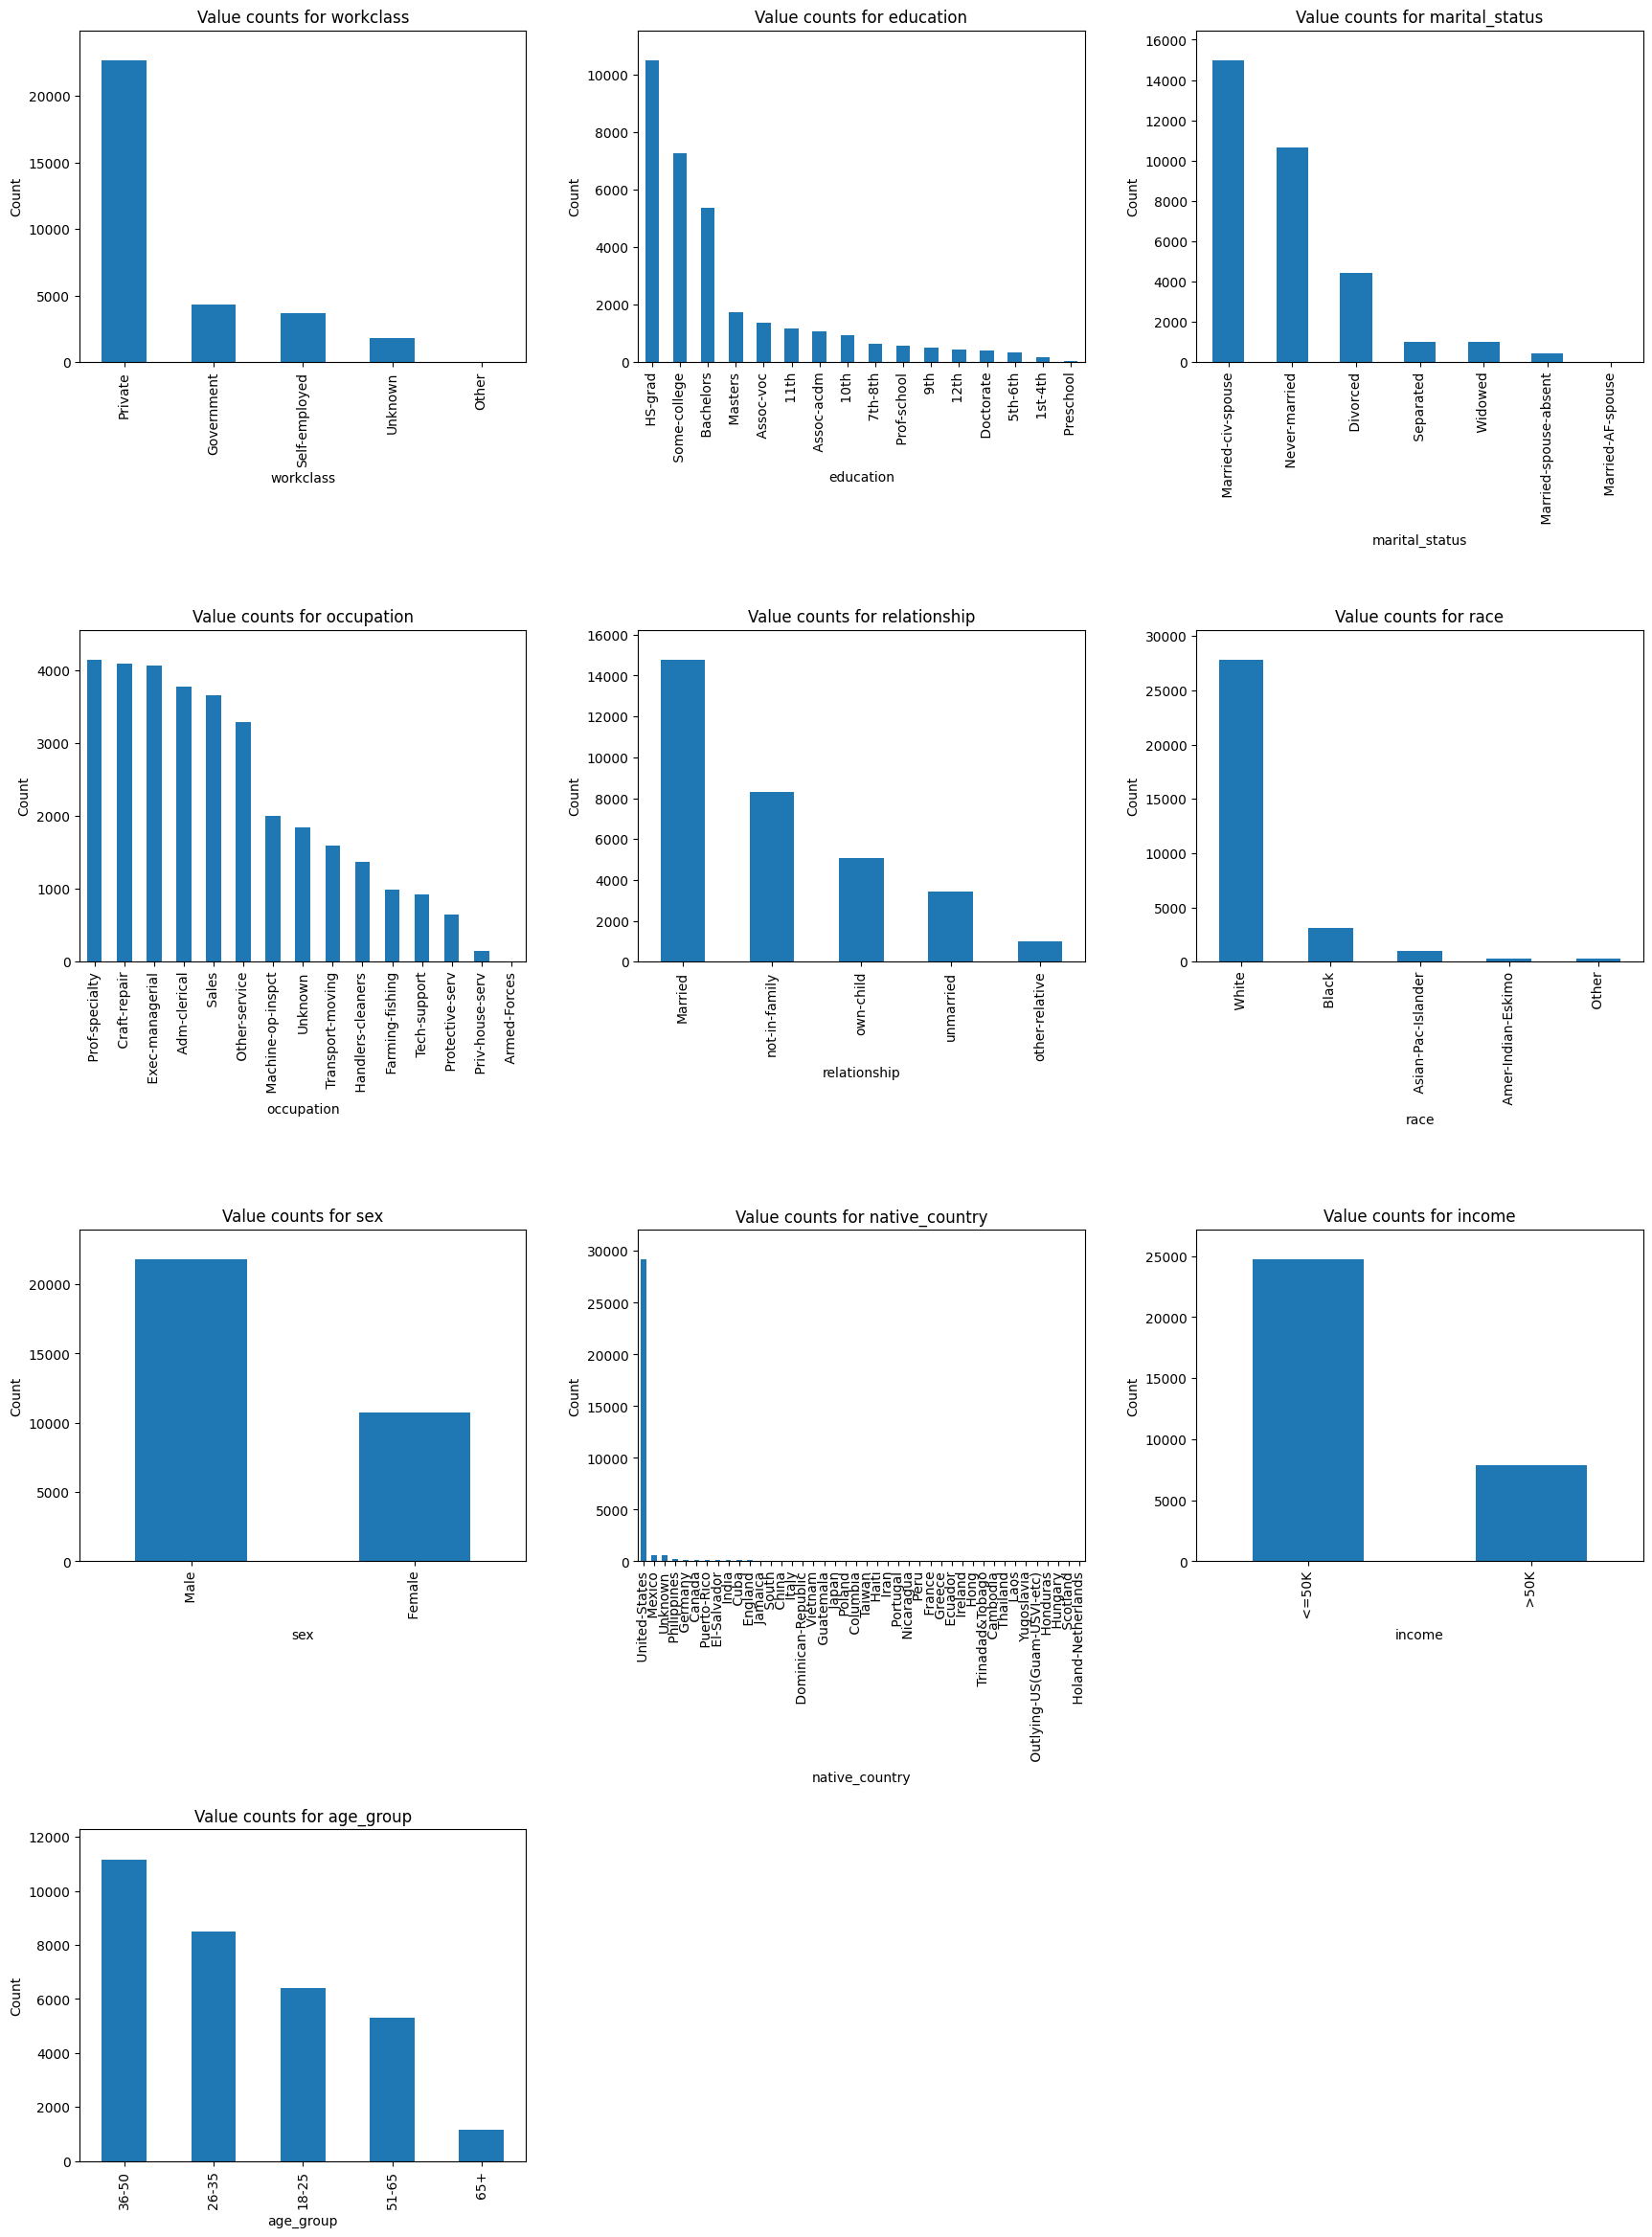

In [6]:
categorical_columns = df.select_dtypes(exclude='number').columns
utils.plot_categorical_value_counts(df, categorical_columns).show()

### 2.1.6 Creating Calculated Columns
- A net capital column was proposed as a new calculated column for my analysis, considering capital gains and losses. The formula for this column is `net_capital = capital_gain − capital_loss`.

In [7]:
df['net_capital'] = df['capital_gain'] - df['capital_loss']
